# Impacts for _Shapelet Transform (ST)_ and _WEASEL_ on _UCR GunPoint_

In this notebook, we reproduce the small case study from our paper.

Note that your plots will certainly differ from ours since you fit your own models which will naturally be different.

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("../..")
import timexplain as tx
import experiments.base as ex

## Load the _UCR GunPoint_ dataset

In [2]:
X_train, y_train, X_test, y_test = ex.dataset("ucr", "GunPoint")
size_x = X_train.shape[1]

## Select time series \#2 from the test set as specimen

In [3]:
specimen_idx = 1
x_specimen = X_test[specimen_idx]
y_specimen = y_test[specimen_idx]

## Fit an _ST_ and a _WEASEL_ model and check their predictions of the specimen

In [4]:
st = ex.classifiers.ShapeletTransformClassifier(time_contract_in_mins=0.5)
st.fit(X_train, y_train);

weasel = ex.classifiers.WEASELEnsembleClassifier(window_sizes=np.arange(0.05, 1, 0.05), word_size=[2, 4, 6], norm_mean=[True, False])
weasel.fit(X_train, y_train);

In [5]:
print("True class:       ", y_specimen)
print("ST prediction:    ",     st.predict([x_specimen])[0])
print("WEASEL prediction:", weasel.predict([x_specimen], pbar=False)[0])

True class:        2
ST prediction:     2
WEASEL prediction: 2


## Explain both model's predictions of the specimen

* The prediction by _ST_ will be explained in the time domain using sample replacement and employing background classes.
* The prediction by _WEASEL_ will be explained in the frequency domain using the patch strategy and employing background classes.

In [6]:
st_om = tx.om.TimeSliceOmitter(size_x, time_slicing=30, x_repl=tx.om.x_sample)
st_expl = tx.om.KernelShapExplainer(st_om, st.predict_proba, X_bg=X_test, y_bg=y_test, n_samples=500, n_builds=5, bgcs=True) \
              .explain(x_specimen)

In [7]:
weasel_om = tx.om.FreqDicePatchOmitter(size_x, time_slicing=15, freq_slicing=5, x_patch=tx.om.x_sample)
weasel_expl = tx.om.KernelShapExplainer(weasel_om, weasel.predict_proba, X_bg=X_test, y_bg=y_test, n_samples=500, n_builds=5, bgcs=True) \
                  .explain(x_specimen)

## Plot the impacts towards the true class of the specimen

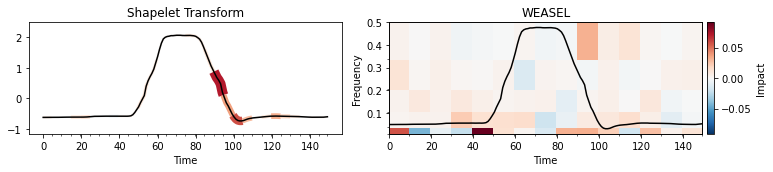

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 2.5))

impact_bound = max(np.max(np.abs(    st_expl.impacts[y_specimen - 1])),
                   np.max(np.abs(weasel_expl.impacts[y_specimen - 1])))

tx.plot.saliency1d(    st_expl, model_output=y_specimen - 1, ax=ax1, impact_bound=impact_bound, legend_style=None, impact_legend=None)
tx.plot.saliency2d(weasel_expl, model_output=y_specimen - 1, ax=ax2, impact_bound=impact_bound, legend_style=None)

ax1.margins(y=0.15)
ax1.set_title("Shapelet Transform")
ax2.set_title("WEASEL")
fig.tight_layout()